# WGAN (Wasserstein GAN)

- 학습 안정성을 위해 wasserstein loss 사용

- loss function : Wasserstein Distance (= Earth Mover's (EM) Distance) : 두개의 분포를 동일하게 만들기 위해 한 분포의 질량 (mass) 를 이동시키는데 필요한 최소 비용 측정 

- D 대신 C (Critic) 사용 -> Real의 분포에 가까운지, Fake의 분포에 가까운지에 대한 값 (score) 출력

In [1]:
import torch

from torchvision.transforms import Compose, ToTensor, Normalize
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from torch.nn import Module, Sequential, ReLU, Tanh, LeakyReLU, ConvTranspose2d, BatchNorm2d, Conv2d, init
from torch.optim import Adam
from torchvision.utils import make_grid

import os
from time import time
from math import floor
import matplotlib.pyplot as plt
import numpy as np

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")

elif torch.xpu.is_available():
    device = torch.device("xpu")

elif torch.backends.mps.is_available():
    device = torch.device("mps")

else: 
    device = torch.device("cpu")

device

device(type='cuda')

In [3]:
transform = Compose([
    ToTensor(),
    Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = DataLoader(CIFAR10(root="data_cifar10", train=True, download=True, transform=transform),
                      batch_size=256,
                      shuffle=True,
                      num_workers=os.cpu_count()//2,
                      pin_memory=True,
                      persistent_workers=True
)

In [4]:
class Generator(Module):
    def __init__(self, latent_size):
        super().__init__()
        
        self.model = Sequential(
            ConvTranspose2d(latent_size, 1024, 4, 1, 0, bias=False),
            BatchNorm2d(1024),
            ReLU(True),

            ConvTranspose2d(1024, 512, 4, 2, 1, bias=False),
            BatchNorm2d(512),
            ReLU(True),

            ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            BatchNorm2d(256),
            ReLU(True),

            ConvTranspose2d(256, 128, 4, 2, 1, bias=False), 
            BatchNorm2d(128),
            ReLU(True),

            ConvTranspose2d(128, 3, 3, 1, 1, bias=False), 
            Tanh()
        )

    def forward(self, z):
        return self.model(z.view(-1, self.model[0].in_channels, 1, 1))

In [ ]:
# 생성된 image가 real data의 분포에 가까운지 fake data의 분포에 가까운지 실수 값 계산
class Critic(Module):
    def __init__(self):
        super().__init__()

        self.model = Sequential(
            Conv2d(3, 64, 4, 2, 1, bias=False),
            LeakyReLU(0.2, inplace=True),
            
            Conv2d(64, 128, 4, 2, 1, bias=False),
            LeakyReLU(0.2, inplace=True),
            
            Conv2d(128, 256, 4, 2, 1, bias=False),
            LeakyReLU(0.2, inplace=True),
        
            # 최종 출력은 1 channel, 실수 값으로 분포를 평가
            Conv2d(256, 1, 4, 1, 0, bias=False),
        )
    
    def forward(self, x):
        # (batch_size, 1) -> 분포를 평가한 score 값
        return self.model(x).view(-1, 1)


In [6]:
# Gradient Penalty 계산
# Critic의 gradient 가 1이 되도록 정규화 (1에서 얼마나 벗어났는지를 구하고, 그 차이를 penalty로 더해줌)
def compute_gradient_penalty(C, real_image, fake_image, device):
    # batch_size c, h, w
    batch_size, _, _, _ = real_image.size()
    
    # epsilon : 0과 1 사이에서 균등 분포를 가진 랜덤 값
    epsilon = torch.rand(batch_size, 1, 1, 1).to(device)

    # real image와 fake image를 선형 보간
    interpolated_image = epsilon * real_image + ((1 - epsilon) * fake_image)
    interpolated_image.requires_grad_(True)
    
    # real과 fake의 분포 차이 계산
    c_interpolated = C(interpolated_image)
    grad_outputs = torch.ones_like(c_interpolated)
    
    # 기울기 계산
    # outputs=c_interpolated: 출력 텐서.
    # inputs=interpolated_samples: 기울기를 계산할 입력 텐서
    # grad_outputs=grad_outputs: 기울기 계산을 위한 출력 텐서의 기울기
    # create_graph=True: 기울기에 대해 다시 그래프를 생성하도록 설정
    # retain_graph=True: 그래프를 유지하여 이후의 연산에서 사용할 수 있도록 설정
    # only_inputs=True: 입력 텐서에 대해서만 기울기를 계산
    # result 가 tuple 형태로 나오기 때문에, 0번지 (기울기) / 1번지 (기울기와 관련된 텐서 정보) 중 0번지만 가져옴
    gradient = torch.autograd.grad(
        outputs=c_interpolated,
        inputs=interpolated_image,
        grad_outputs=grad_outputs,
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]
    
    gradient = gradient.view(batch_size, -1)

    # L2 Norm(Euclidean distance) 계산
    gradient_penalty = ((gradient.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

In [7]:
latent_size = 100

G = Generator(latent_size).to(device)
C = Critic().to(device)

In [8]:
# He 초기화 : 입력 뉴런 수에 비례하는 분산을 사용하여 가중치를 초기화
def weights_init(model):
    if isinstance(model, (Conv2d, ConvTranspose2d)):
        init.kaiming_normal_(model.weight.data, mode='fan_in', nonlinearity='relu')  
    elif isinstance(model, BatchNorm2d):
        init.normal_(model.weight.data, 1.0, 0.02)
        init.constant_(model.bias.data, 0)

print(G.apply(weights_init))
print(C.apply(weights_init))

Generator(
  (model): Sequential(
    (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(128, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (13): Tanh()

In [9]:
# Loss function
def wgan_loss(real_output, fake_output):
    return torch.mean(fake_output) - torch.mean(real_output)


learning_rate = 0.0001

betas = (0.5, 0.999)

g_optimizer = Adam(G.parameters(), lr=learning_rate, betas=betas)
c_optimizer = Adam(C.parameters(), lr=learning_rate, betas=betas)

epoch:   1/300 	 C Loss: -146.789 G Loss: 316.389 	 37s
epoch:   2/300 	 C Loss: -8.306 G Loss: 13.574 	 13s
epoch:   3/300 	 C Loss: -5.070 G Loss: 8.572 	 13s
epoch:   4/300 	 C Loss: -5.365 G Loss: 5.735 	 13s
epoch:   5/300 	 C Loss: -6.812 G Loss: 3.908 	 13s
epoch:   6/300 	 C Loss: -7.375 G Loss: 3.419 	 13s
epoch:   7/300 	 C Loss: -8.496 G Loss: 3.593 	 13s
epoch:   8/300 	 C Loss: -8.204 G Loss: 5.526 	 13s
epoch:   9/300 	 C Loss: -7.194 G Loss: 4.684 	 13s
epoch:  10/300 	 C Loss: -6.213 G Loss: 4.661 	 13s


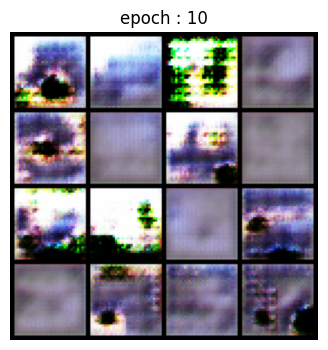

epoch:  11/300 	 C Loss: -6.113 G Loss: 3.831 	 13s
epoch:  12/300 	 C Loss: -5.637 G Loss: 3.066 	 13s
epoch:  13/300 	 C Loss: -5.087 G Loss: 2.647 	 13s
epoch:  14/300 	 C Loss: -4.442 G Loss: 2.219 	 13s
epoch:  15/300 	 C Loss: -4.460 G Loss: 2.305 	 13s
epoch:  16/300 	 C Loss: -4.341 G Loss: 1.923 	 13s
epoch:  17/300 	 C Loss: -4.253 G Loss: 2.331 	 14s
epoch:  18/300 	 C Loss: -4.249 G Loss: 2.051 	 14s
epoch:  19/300 	 C Loss: -3.990 G Loss: 2.210 	 14s
epoch:  20/300 	 C Loss: -3.811 G Loss: 2.511 	 14s


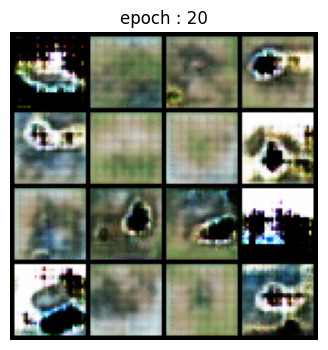

epoch:  21/300 	 C Loss: -3.594 G Loss: 2.199 	 14s
epoch:  22/300 	 C Loss: -3.604 G Loss: 2.156 	 14s
epoch:  23/300 	 C Loss: -3.460 G Loss: 2.229 	 14s
epoch:  24/300 	 C Loss: -3.317 G Loss: 2.138 	 14s
epoch:  25/300 	 C Loss: -3.227 G Loss: 1.774 	 14s
epoch:  26/300 	 C Loss: -3.123 G Loss: 2.078 	 14s
epoch:  27/300 	 C Loss: -3.018 G Loss: 1.988 	 14s
epoch:  28/300 	 C Loss: -2.961 G Loss: 1.944 	 14s
epoch:  29/300 	 C Loss: -3.016 G Loss: 1.936 	 14s
epoch:  30/300 	 C Loss: -2.922 G Loss: 1.872 	 14s


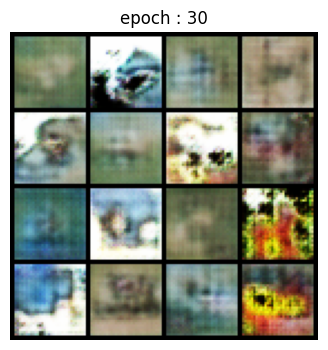

epoch:  31/300 	 C Loss: -2.905 G Loss: 1.358 	 14s
epoch:  32/300 	 C Loss: -2.864 G Loss: 1.704 	 14s
epoch:  33/300 	 C Loss: -2.801 G Loss: 1.849 	 14s
epoch:  34/300 	 C Loss: -2.756 G Loss: 1.548 	 14s
epoch:  35/300 	 C Loss: -2.662 G Loss: 1.545 	 14s
epoch:  36/300 	 C Loss: -2.586 G Loss: 1.504 	 14s
epoch:  37/300 	 C Loss: -2.520 G Loss: 1.499 	 14s
epoch:  38/300 	 C Loss: -2.426 G Loss: 1.495 	 14s
epoch:  39/300 	 C Loss: -2.353 G Loss: 1.339 	 14s
epoch:  40/300 	 C Loss: -2.286 G Loss: 1.474 	 14s


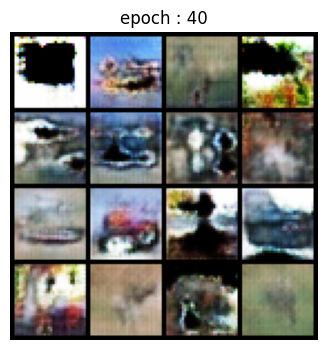

epoch:  41/300 	 C Loss: -2.246 G Loss: 1.262 	 14s
epoch:  42/300 	 C Loss: -2.237 G Loss: 1.283 	 14s
epoch:  43/300 	 C Loss: -2.236 G Loss: 1.636 	 14s
epoch:  44/300 	 C Loss: -2.217 G Loss: 1.041 	 14s
epoch:  45/300 	 C Loss: -2.092 G Loss: 1.257 	 14s
epoch:  46/300 	 C Loss: -2.078 G Loss: 1.045 	 14s
epoch:  47/300 	 C Loss: -2.103 G Loss: 0.934 	 14s
epoch:  48/300 	 C Loss: -2.053 G Loss: 1.289 	 14s
epoch:  49/300 	 C Loss: -1.994 G Loss: 1.130 	 14s
epoch:  50/300 	 C Loss: -2.142 G Loss: 1.431 	 14s


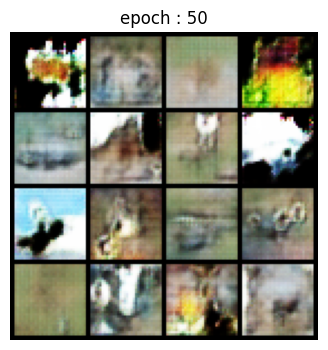

epoch:  51/300 	 C Loss: -1.798 G Loss: 1.138 	 14s
epoch:  52/300 	 C Loss: -1.936 G Loss: 0.802 	 14s
epoch:  53/300 	 C Loss: -1.876 G Loss: 1.068 	 14s
epoch:  54/300 	 C Loss: -1.863 G Loss: 1.064 	 14s
epoch:  55/300 	 C Loss: -1.798 G Loss: 0.943 	 14s
epoch:  56/300 	 C Loss: -1.765 G Loss: 1.019 	 14s
epoch:  57/300 	 C Loss: -1.745 G Loss: 0.767 	 14s
epoch:  58/300 	 C Loss: -1.745 G Loss: 0.862 	 14s
epoch:  59/300 	 C Loss: -1.619 G Loss: 1.063 	 14s
epoch:  60/300 	 C Loss: -1.679 G Loss: 0.819 	 14s


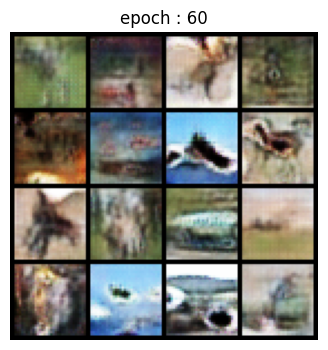

epoch:  61/300 	 C Loss: -1.574 G Loss: 0.820 	 14s
epoch:  62/300 	 C Loss: -1.554 G Loss: 0.924 	 14s
epoch:  63/300 	 C Loss: -1.553 G Loss: 0.665 	 14s
epoch:  64/300 	 C Loss: -1.537 G Loss: 0.610 	 14s
epoch:  65/300 	 C Loss: -1.613 G Loss: 1.198 	 14s
epoch:  66/300 	 C Loss: -1.442 G Loss: 0.666 	 14s
epoch:  67/300 	 C Loss: -1.481 G Loss: 0.713 	 14s
epoch:  68/300 	 C Loss: -1.456 G Loss: 0.629 	 14s
epoch:  69/300 	 C Loss: -1.438 G Loss: 0.634 	 14s
epoch:  70/300 	 C Loss: -1.515 G Loss: 0.601 	 14s


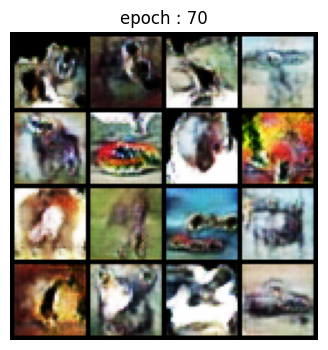

epoch:  71/300 	 C Loss: -1.597 G Loss: 1.703 	 14s
epoch:  72/300 	 C Loss: -1.374 G Loss: 0.566 	 14s
epoch:  73/300 	 C Loss: -1.286 G Loss: 0.562 	 14s
epoch:  74/300 	 C Loss: -1.404 G Loss: 0.810 	 14s
epoch:  75/300 	 C Loss: -1.408 G Loss: 0.618 	 14s
epoch:  76/300 	 C Loss: -1.283 G Loss: 0.724 	 14s
epoch:  77/300 	 C Loss: -1.321 G Loss: 0.418 	 14s
epoch:  78/300 	 C Loss: -1.291 G Loss: 0.633 	 14s
epoch:  79/300 	 C Loss: -1.371 G Loss: 0.498 	 14s
epoch:  80/300 	 C Loss: -1.325 G Loss: 1.075 	 14s


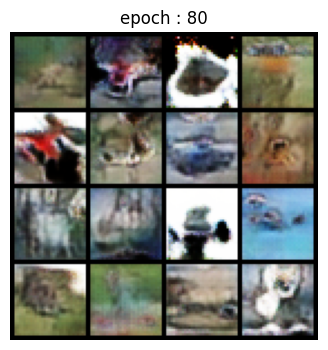

epoch:  81/300 	 C Loss: -1.253 G Loss: 0.592 	 14s
epoch:  82/300 	 C Loss: -1.275 G Loss: 0.353 	 14s
epoch:  83/300 	 C Loss: -1.223 G Loss: 0.799 	 14s
epoch:  84/300 	 C Loss: -1.236 G Loss: 0.369 	 14s
epoch:  85/300 	 C Loss: -1.255 G Loss: 0.830 	 14s
epoch:  86/300 	 C Loss: -1.351 G Loss: 0.894 	 13s
epoch:  87/300 	 C Loss: -1.246 G Loss: 0.393 	 13s
epoch:  88/300 	 C Loss: -1.338 G Loss: 1.230 	 13s
epoch:  89/300 	 C Loss: -1.221 G Loss: 0.631 	 13s
epoch:  90/300 	 C Loss: -1.161 G Loss: 0.722 	 13s


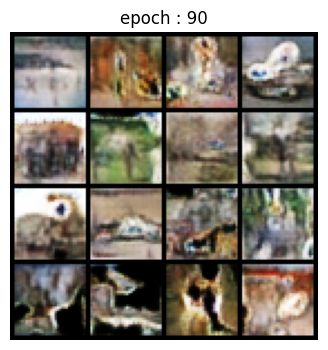

epoch:  91/300 	 C Loss: -1.108 G Loss: 0.270 	 13s
epoch:  92/300 	 C Loss: -1.158 G Loss: 0.682 	 13s
epoch:  93/300 	 C Loss: -1.224 G Loss: 0.586 	 13s
epoch:  94/300 	 C Loss: -1.189 G Loss: 0.218 	 13s
epoch:  95/300 	 C Loss: -1.191 G Loss: 1.147 	 13s
epoch:  96/300 	 C Loss: -1.132 G Loss: 0.331 	 13s
epoch:  97/300 	 C Loss: -1.151 G Loss: 0.130 	 13s
epoch:  98/300 	 C Loss: -1.138 G Loss: 0.723 	 13s
epoch:  99/300 	 C Loss: -1.275 G Loss: 0.972 	 13s
epoch: 100/300 	 C Loss: -1.117 G Loss: 0.128 	 13s


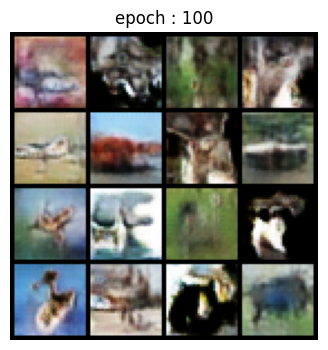

epoch: 101/300 	 C Loss: -1.066 G Loss: 0.628 	 13s
epoch: 102/300 	 C Loss: -1.083 G Loss: 0.708 	 13s
epoch: 103/300 	 C Loss: -1.189 G Loss: 0.634 	 13s
epoch: 104/300 	 C Loss: -1.014 G Loss: 0.636 	 14s
epoch: 105/300 	 C Loss: -1.038 G Loss: 0.423 	 14s
epoch: 106/300 	 C Loss: -1.093 G Loss: 0.116 	 14s
epoch: 107/300 	 C Loss: -1.096 G Loss: 0.749 	 14s
epoch: 108/300 	 C Loss: -1.037 G Loss: 0.365 	 14s
epoch: 109/300 	 C Loss: -1.167 G Loss: 0.329 	 14s
epoch: 110/300 	 C Loss: -1.091 G Loss: 0.796 	 14s


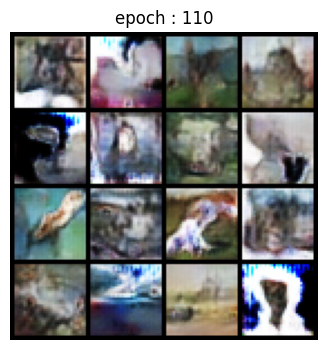

epoch: 111/300 	 C Loss: -1.024 G Loss: 0.773 	 14s
epoch: 112/300 	 C Loss: -1.012 G Loss: 0.455 	 14s
epoch: 113/300 	 C Loss: -1.114 G Loss: 0.195 	 14s
epoch: 114/300 	 C Loss: -1.034 G Loss: 1.233 	 14s
epoch: 115/300 	 C Loss: -0.940 G Loss: 0.000 	 14s
epoch: 116/300 	 C Loss: -1.038 G Loss: 0.460 	 14s
epoch: 117/300 	 C Loss: -1.047 G Loss: 0.584 	 14s
epoch: 118/300 	 C Loss: -1.024 G Loss: 0.330 	 14s
epoch: 119/300 	 C Loss: -1.018 G Loss: 0.893 	 14s
epoch: 120/300 	 C Loss: -1.047 G Loss: 0.114 	 14s


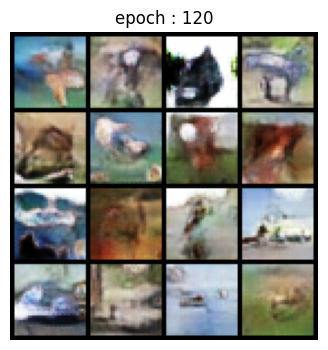

epoch: 121/300 	 C Loss: -1.084 G Loss: 0.704 	 14s
epoch: 122/300 	 C Loss: -1.008 G Loss: 0.190 	 14s
epoch: 123/300 	 C Loss: -1.095 G Loss: 0.665 	 14s
epoch: 124/300 	 C Loss: -0.982 G Loss: 0.545 	 14s
epoch: 125/300 	 C Loss: -1.039 G Loss: 0.094 	 14s
epoch: 126/300 	 C Loss: -0.991 G Loss: 0.296 	 14s
epoch: 127/300 	 C Loss: -1.032 G Loss: 0.413 	 14s
epoch: 128/300 	 C Loss: -0.972 G Loss: 0.962 	 14s
epoch: 129/300 	 C Loss: -0.973 G Loss: 0.143 	 14s
epoch: 130/300 	 C Loss: -0.994 G Loss: 0.480 	 14s


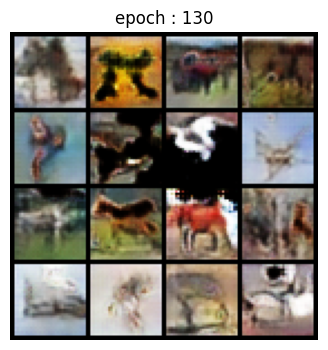

epoch: 131/300 	 C Loss: -1.074 G Loss: 1.013 	 14s
epoch: 132/300 	 C Loss: -0.895 G Loss: -0.138 	 14s
epoch: 133/300 	 C Loss: -0.903 G Loss: 1.028 	 14s
epoch: 134/300 	 C Loss: -0.983 G Loss: 0.080 	 14s
epoch: 135/300 	 C Loss: -0.922 G Loss: 0.605 	 14s
epoch: 136/300 	 C Loss: -0.970 G Loss: 0.054 	 14s
epoch: 137/300 	 C Loss: -0.965 G Loss: 0.625 	 14s
epoch: 138/300 	 C Loss: -1.018 G Loss: 0.370 	 14s
epoch: 139/300 	 C Loss: -0.946 G Loss: 0.277 	 14s
epoch: 140/300 	 C Loss: -0.986 G Loss: 0.299 	 14s


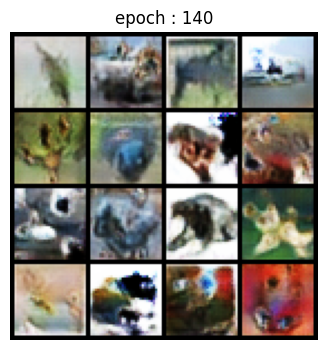

epoch: 141/300 	 C Loss: -0.961 G Loss: 0.433 	 14s
epoch: 142/300 	 C Loss: -1.136 G Loss: 0.872 	 14s
epoch: 143/300 	 C Loss: -0.870 G Loss: 0.620 	 14s
epoch: 144/300 	 C Loss: -0.823 G Loss: 0.211 	 14s
epoch: 145/300 	 C Loss: -0.883 G Loss: 0.456 	 14s
epoch: 146/300 	 C Loss: -0.947 G Loss: 0.157 	 14s
epoch: 147/300 	 C Loss: -0.881 G Loss: 0.529 	 14s
epoch: 148/300 	 C Loss: -0.951 G Loss: 0.405 	 14s
epoch: 149/300 	 C Loss: -0.930 G Loss: 0.161 	 14s
epoch: 150/300 	 C Loss: -0.912 G Loss: 0.503 	 14s


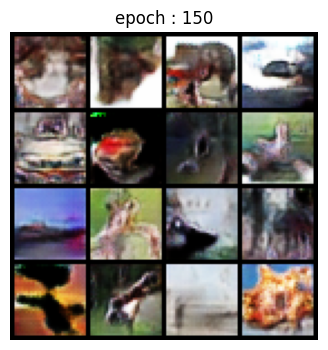

epoch: 151/300 	 C Loss: -0.885 G Loss: 0.278 	 14s
epoch: 152/300 	 C Loss: -0.995 G Loss: 0.277 	 14s
epoch: 153/300 	 C Loss: -0.968 G Loss: 0.711 	 14s
epoch: 154/300 	 C Loss: -0.770 G Loss: 0.285 	 14s
epoch: 155/300 	 C Loss: -0.827 G Loss: 0.075 	 14s
epoch: 156/300 	 C Loss: -0.876 G Loss: 0.237 	 14s
epoch: 157/300 	 C Loss: -0.933 G Loss: 0.399 	 14s
epoch: 158/300 	 C Loss: -0.898 G Loss: 0.434 	 14s
epoch: 159/300 	 C Loss: -0.914 G Loss: 0.517 	 14s
epoch: 160/300 	 C Loss: -0.998 G Loss: 0.310 	 14s


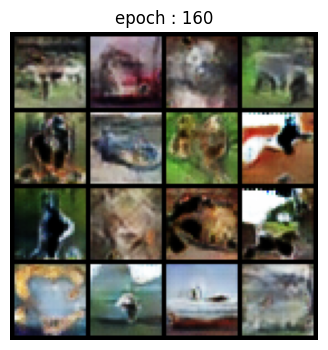

epoch: 161/300 	 C Loss: -1.028 G Loss: 0.525 	 14s
epoch: 162/300 	 C Loss: -0.868 G Loss: 0.588 	 14s
epoch: 163/300 	 C Loss: -0.878 G Loss: 0.607 	 14s
epoch: 164/300 	 C Loss: -0.791 G Loss: -0.141 	 14s
epoch: 165/300 	 C Loss: -0.822 G Loss: 0.359 	 14s
epoch: 166/300 	 C Loss: -0.829 G Loss: 0.389 	 14s
epoch: 167/300 	 C Loss: -0.844 G Loss: 0.311 	 14s
epoch: 168/300 	 C Loss: -0.881 G Loss: 0.603 	 14s
epoch: 169/300 	 C Loss: -0.890 G Loss: 0.317 	 14s
epoch: 170/300 	 C Loss: -0.940 G Loss: 0.128 	 14s


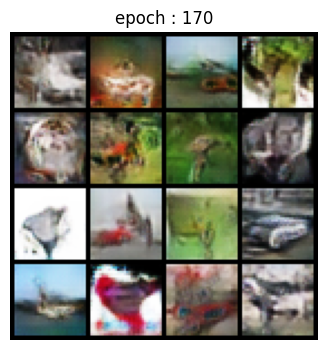

epoch: 171/300 	 C Loss: -0.882 G Loss: 0.468 	 14s
epoch: 172/300 	 C Loss: -0.881 G Loss: 0.484 	 14s
epoch: 173/300 	 C Loss: -0.853 G Loss: 0.008 	 14s
epoch: 174/300 	 C Loss: -0.874 G Loss: 0.233 	 14s
epoch: 175/300 	 C Loss: -0.869 G Loss: 0.439 	 14s
epoch: 176/300 	 C Loss: -1.030 G Loss: 0.480 	 14s
epoch: 177/300 	 C Loss: -0.756 G Loss: 0.527 	 14s
epoch: 178/300 	 C Loss: -0.866 G Loss: 0.165 	 14s
epoch: 179/300 	 C Loss: -0.848 G Loss: -0.093 	 14s
epoch: 180/300 	 C Loss: -0.875 G Loss: 0.707 	 14s


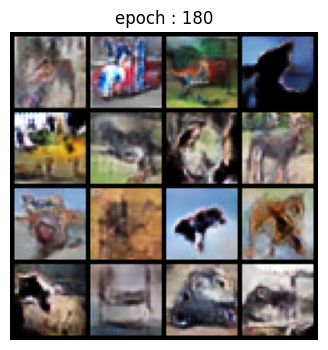

epoch: 181/300 	 C Loss: -0.835 G Loss: 0.415 	 14s
epoch: 182/300 	 C Loss: -0.830 G Loss: 0.313 	 14s
epoch: 183/300 	 C Loss: -0.853 G Loss: 0.023 	 14s
epoch: 184/300 	 C Loss: -0.843 G Loss: 0.269 	 14s
epoch: 185/300 	 C Loss: -0.836 G Loss: 0.306 	 14s
epoch: 186/300 	 C Loss: -0.843 G Loss: 0.031 	 14s
epoch: 187/300 	 C Loss: -0.875 G Loss: 0.823 	 14s
epoch: 188/300 	 C Loss: -0.867 G Loss: 0.208 	 14s
epoch: 189/300 	 C Loss: -0.782 G Loss: 0.248 	 14s
epoch: 190/300 	 C Loss: -0.778 G Loss: 0.058 	 14s


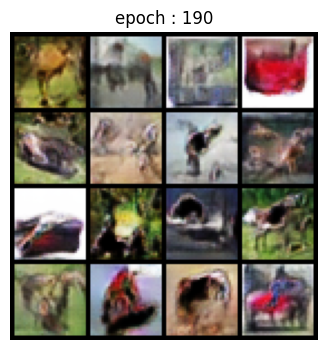

epoch: 191/300 	 C Loss: -0.839 G Loss: 0.324 	 14s
epoch: 192/300 	 C Loss: -0.923 G Loss: 0.464 	 14s
epoch: 193/300 	 C Loss: -0.793 G Loss: 0.624 	 14s
epoch: 194/300 	 C Loss: -0.833 G Loss: -0.207 	 14s
epoch: 195/300 	 C Loss: -0.772 G Loss: 0.705 	 14s
epoch: 196/300 	 C Loss: -0.822 G Loss: -0.083 	 14s
epoch: 197/300 	 C Loss: -0.878 G Loss: 0.141 	 14s
epoch: 198/300 	 C Loss: -0.899 G Loss: 1.056 	 14s
epoch: 199/300 	 C Loss: -0.697 G Loss: -0.032 	 14s
epoch: 200/300 	 C Loss: -0.702 G Loss: 0.359 	 14s


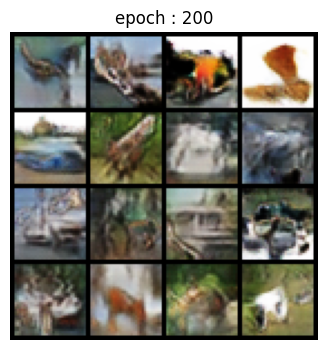

epoch: 201/300 	 C Loss: -0.771 G Loss: 0.251 	 14s
epoch: 202/300 	 C Loss: -0.813 G Loss: 0.278 	 14s
epoch: 203/300 	 C Loss: -0.824 G Loss: 0.048 	 14s
epoch: 204/300 	 C Loss: -0.856 G Loss: 0.064 	 14s
epoch: 205/300 	 C Loss: -0.815 G Loss: 0.383 	 14s
epoch: 206/300 	 C Loss: -0.808 G Loss: 0.216 	 14s
epoch: 207/300 	 C Loss: -0.961 G Loss: 0.957 	 14s
epoch: 208/300 	 C Loss: -0.780 G Loss: -0.113 	 14s
epoch: 209/300 	 C Loss: -0.751 G Loss: 0.288 	 14s
epoch: 210/300 	 C Loss: -0.824 G Loss: 0.445 	 14s


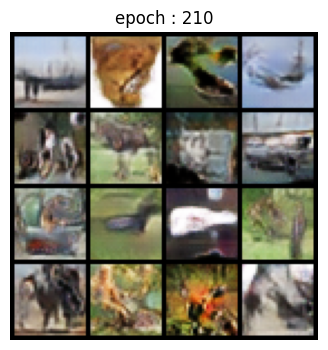

epoch: 211/300 	 C Loss: -0.823 G Loss: -0.103 	 14s
epoch: 212/300 	 C Loss: -0.783 G Loss: 0.166 	 14s
epoch: 213/300 	 C Loss: -0.786 G Loss: 0.333 	 14s
epoch: 214/300 	 C Loss: -0.853 G Loss: -0.048 	 14s
epoch: 215/300 	 C Loss: -0.782 G Loss: 0.367 	 14s
epoch: 216/300 	 C Loss: -0.807 G Loss: 0.273 	 14s
epoch: 217/300 	 C Loss: -0.856 G Loss: 0.553 	 14s
epoch: 218/300 	 C Loss: -0.753 G Loss: 0.333 	 14s
epoch: 219/300 	 C Loss: -0.809 G Loss: 0.027 	 14s
epoch: 220/300 	 C Loss: -0.798 G Loss: 0.345 	 14s


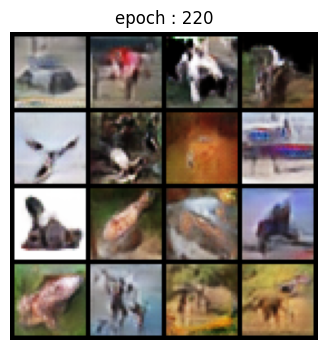

epoch: 221/300 	 C Loss: -0.793 G Loss: 0.376 	 14s
epoch: 222/300 	 C Loss: -0.890 G Loss: 0.116 	 14s
epoch: 223/300 	 C Loss: -0.758 G Loss: 0.479 	 14s
epoch: 224/300 	 C Loss: -0.745 G Loss: 0.155 	 14s
epoch: 225/300 	 C Loss: -0.783 G Loss: -0.049 	 14s
epoch: 226/300 	 C Loss: -0.778 G Loss: 0.337 	 14s
epoch: 227/300 	 C Loss: -0.950 G Loss: 0.462 	 14s
epoch: 228/300 	 C Loss: -0.721 G Loss: 0.643 	 14s
epoch: 229/300 	 C Loss: -0.858 G Loss: -0.316 	 14s
epoch: 230/300 	 C Loss: -0.773 G Loss: 0.743 	 14s


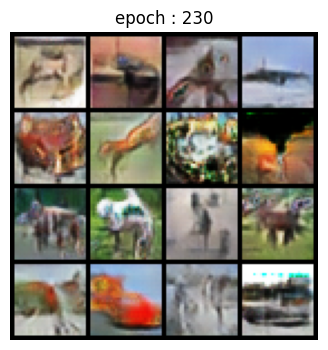

epoch: 231/300 	 C Loss: -0.769 G Loss: 0.263 	 14s
epoch: 232/300 	 C Loss: -0.769 G Loss: -0.203 	 14s
epoch: 233/300 	 C Loss: -0.770 G Loss: 0.232 	 14s
epoch: 234/300 	 C Loss: -0.775 G Loss: 0.223 	 14s
epoch: 235/300 	 C Loss: -0.778 G Loss: -0.000 	 14s
epoch: 236/300 	 C Loss: -0.801 G Loss: 0.398 	 14s
epoch: 237/300 	 C Loss: -0.810 G Loss: -0.040 	 14s
epoch: 238/300 	 C Loss: -0.797 G Loss: 0.238 	 14s
epoch: 239/300 	 C Loss: -0.799 G Loss: 0.488 	 14s
epoch: 240/300 	 C Loss: -0.776 G Loss: -0.054 	 14s


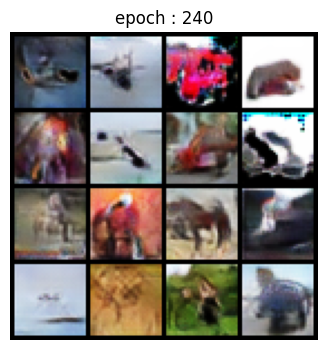

epoch: 241/300 	 C Loss: -0.800 G Loss: 0.239 	 14s
epoch: 242/300 	 C Loss: -0.747 G Loss: 0.017 	 14s
epoch: 243/300 	 C Loss: -0.806 G Loss: 0.776 	 14s
epoch: 244/300 	 C Loss: -0.741 G Loss: 0.336 	 14s
epoch: 245/300 	 C Loss: -0.859 G Loss: -0.361 	 14s
epoch: 246/300 	 C Loss: -0.774 G Loss: 0.426 	 14s
epoch: 247/300 	 C Loss: -0.760 G Loss: 0.163 	 14s
epoch: 248/300 	 C Loss: -0.775 G Loss: 0.273 	 14s
epoch: 249/300 	 C Loss: -0.848 G Loss: 0.167 	 14s
epoch: 250/300 	 C Loss: -0.713 G Loss: 0.359 	 14s


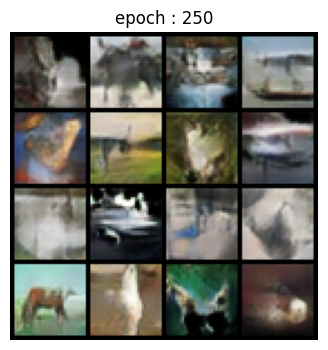

epoch: 251/300 	 C Loss: -0.743 G Loss: 0.219 	 14s
epoch: 252/300 	 C Loss: -0.795 G Loss: 0.162 	 14s
epoch: 253/300 	 C Loss: -0.767 G Loss: 0.829 	 14s
epoch: 254/300 	 C Loss: -0.692 G Loss: -0.139 	 14s
epoch: 255/300 	 C Loss: -0.836 G Loss: -0.181 	 14s
epoch: 256/300 	 C Loss: -0.729 G Loss: 0.623 	 14s
epoch: 257/300 	 C Loss: -0.754 G Loss: 0.058 	 14s
epoch: 258/300 	 C Loss: -0.760 G Loss: 0.148 	 14s
epoch: 259/300 	 C Loss: -0.785 G Loss: 0.301 	 14s
epoch: 260/300 	 C Loss: -0.761 G Loss: -0.005 	 14s


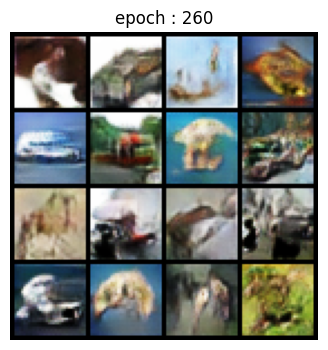

epoch: 261/300 	 C Loss: -0.748 G Loss: 0.224 	 14s
epoch: 262/300 	 C Loss: -0.817 G Loss: 0.041 	 14s
epoch: 263/300 	 C Loss: -0.838 G Loss: 0.096 	 14s
epoch: 264/300 	 C Loss: -0.908 G Loss: 0.624 	 14s
epoch: 265/300 	 C Loss: -0.687 G Loss: 0.392 	 14s
epoch: 266/300 	 C Loss: -0.700 G Loss: 0.092 	 14s
epoch: 267/300 	 C Loss: -0.757 G Loss: -0.152 	 14s
epoch: 268/300 	 C Loss: -0.790 G Loss: 0.228 	 14s
epoch: 269/300 	 C Loss: -0.708 G Loss: 0.740 	 14s
epoch: 270/300 	 C Loss: -0.745 G Loss: -0.446 	 14s


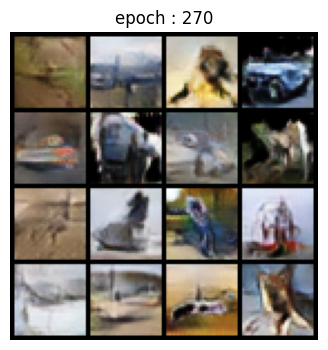

epoch: 271/300 	 C Loss: -0.746 G Loss: 0.404 	 13s
epoch: 272/300 	 C Loss: -0.802 G Loss: 0.129 	 13s
epoch: 273/300 	 C Loss: -0.767 G Loss: 0.109 	 13s
epoch: 274/300 	 C Loss: -0.767 G Loss: 0.438 	 13s
epoch: 275/300 	 C Loss: -0.909 G Loss: -0.351 	 14s
epoch: 276/300 	 C Loss: -0.733 G Loss: 0.824 	 14s
epoch: 277/300 	 C Loss: -0.717 G Loss: 0.174 	 13s
epoch: 278/300 	 C Loss: -0.748 G Loss: -0.048 	 13s
epoch: 279/300 	 C Loss: -0.838 G Loss: 0.790 	 13s
epoch: 280/300 	 C Loss: -0.803 G Loss: 0.105 	 13s


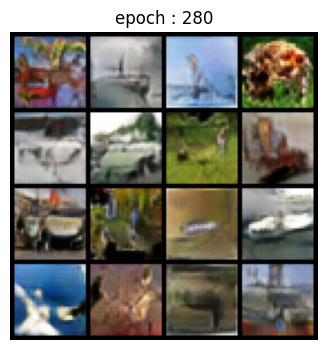

epoch: 281/300 	 C Loss: -0.679 G Loss: -0.007 	 13s
epoch: 282/300 	 C Loss: -0.683 G Loss: 0.116 	 13s
epoch: 283/300 	 C Loss: -0.705 G Loss: 0.386 	 13s
epoch: 284/300 	 C Loss: -0.745 G Loss: -0.160 	 13s
epoch: 285/300 	 C Loss: -0.751 G Loss: 0.315 	 13s
epoch: 286/300 	 C Loss: -0.793 G Loss: 0.197 	 13s
epoch: 287/300 	 C Loss: -0.729 G Loss: 0.320 	 13s
epoch: 288/300 	 C Loss: -0.789 G Loss: 0.100 	 13s
epoch: 289/300 	 C Loss: -0.767 G Loss: -0.050 	 13s
epoch: 290/300 	 C Loss: -0.742 G Loss: 0.433 	 13s


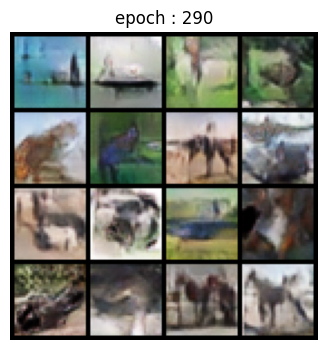

epoch: 291/300 	 C Loss: -0.761 G Loss: 0.110 	 13s
epoch: 292/300 	 C Loss: -0.756 G Loss: 0.256 	 13s
epoch: 293/300 	 C Loss: -0.773 G Loss: 0.023 	 13s
epoch: 294/300 	 C Loss: -0.831 G Loss: 0.416 	 14s
epoch: 295/300 	 C Loss: -0.740 G Loss: -0.393 	 14s
epoch: 296/300 	 C Loss: -0.749 G Loss: 0.683 	 14s
epoch: 297/300 	 C Loss: -0.749 G Loss: 0.239 	 14s
epoch: 298/300 	 C Loss: -0.699 G Loss: 0.042 	 14s
epoch: 299/300 	 C Loss: -0.827 G Loss: 0.130 	 14s
epoch: 300/300 	 C Loss: -0.653 G Loss: 0.200 	 14s


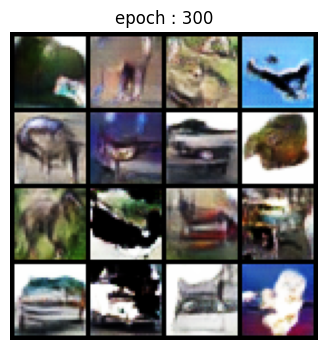

learning time (300 epoch) : 69m 29


In [ ]:
epochs = 300

# Gradient penalty lambda
lambda_gp = 1

total_time = list()

c_loss_list = list()
g_loss_list = list()

for epoch in range(1, epochs+1):
    now = time()
    c_avg_loss = 0.0
    g_avg_loss = 0.0

    for i, data in enumerate(trainset):
        x, _ = data
        x = x.to(device)

        c_optimizer.zero_grad()
        g_optimizer.zero_grad()
        
        batch_size = x.size(0)
        real_labels = torch.ones(batch_size, 1, device=device) * 0.8 + 0.05 * torch.rand(batch_size, 1, device=device)
        fake_labels = torch.zeros(batch_size, 1, device=device) + 0.2 * torch.rand(batch_size, 1, device=device)

        # C training
        for _ in range(3):
            z = torch.randn(batch_size, latent_size, device=device)
            fake_imgs = G(z)

            real_score = C(x)
            fake_score = C(fake_imgs.detach())

            # WGAN-GP Critic Loss: Minimize (Fake Score - Real Score + GP)
            c_loss = torch.mean(fake_score) - torch.mean(real_score)
            c_loss += lambda_gp * compute_gradient_penalty(C, x, fake_imgs.detach(), device)

            c_loss.backward()
            c_optimizer.step()

        # G training
        z = torch.randn(batch_size, latent_size, device=device)
        fake_imgs = G(z)    

        g_loss = -torch.mean(C(fake_imgs))
        g_loss.backward()
        g_optimizer.step()
            
        c_avg_loss += c_loss.item()
        g_avg_loss += g_loss.item()

        c_loss_list.append(c_loss.item())
        g_loss_list.append(g_loss.item())

    learning_time = int(time() - now)
    total_time.append(learning_time)

    print(f"epoch: {epoch:3d}/{epochs} \t C Loss: {c_avg_loss/len(trainset):.3f} G Loss: {g_avg_loss/len(trainset):.3f} \t {learning_time}s")

    if epoch % 10 == 0:
        fake_images = fake_imgs.detach().view(-1, 3, 32, 32)
        plt.figure(figsize=(4, 4))
        plt.imshow(make_grid(fake_images[:16], nrow=4, normalize=True).cpu().permute(1, 2, 0))
        plt.axis('off')
        plt.title(f"epoch : {epoch}")
        plt.show()
    

print(f"learning time ({epochs} epoch) : {floor(sum(total_time) / 60)}m {sum(total_time) % 60}")

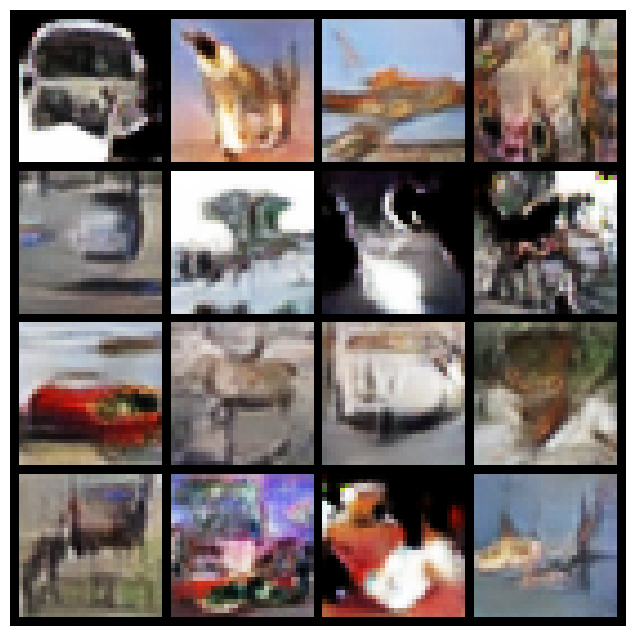

In [11]:
z = torch.randn(batch_size, latent_size, device=device)
fake_images = G(z)

plt.figure(figsize=(8, 8))
plt.imshow(make_grid(fake_images[:16], nrow=4, normalize=True).cpu().permute(1,2,0))
plt.axis("off")
plt.show()

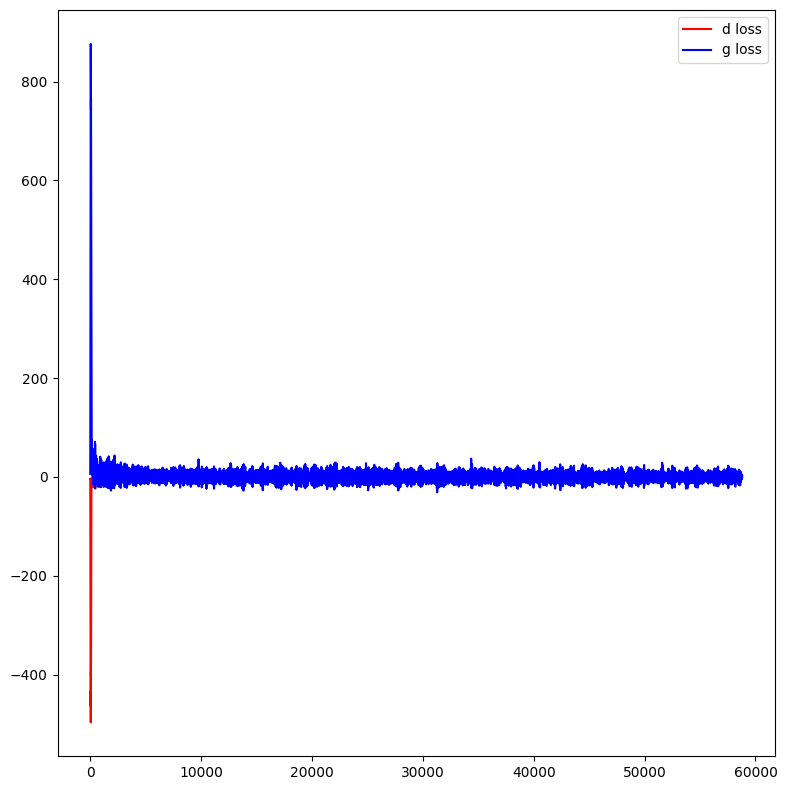

In [12]:
plt.figure(figsize=(8, 8))
plt.plot(range(1, len(c_loss_list) + 1), c_loss_list, label='d loss', color='red')
plt.plot(range(1, len(c_loss_list) + 1), g_loss_list, label='g loss', color='blue')
plt.tight_layout()
plt.legend()
plt.show()

그래프 해석 : loss가 안정화된 것으로 보임 (epoch 300은 너무 많음) -> early stooping 등으로 중간에 종료하는 걸 생각

이미지 품질이 아직은 선명하지 않기 때문에, 하이퍼파라미터 튜닝이 더 필요함